In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import util

In [2]:
import importlib
importlib.reload(util)

<module 'util' from '/Users/ellajones/util.py'>

In [3]:
qqq_df = pd.read_csv("qqq_df.csv") # this is just the combined target and feature parquets and then filter on stock_id=104919

In [4]:
feature_eng_df = util.create_snapshot_features(qqq_df)

In [5]:
folder_path = "/Users/ellajones/Downloads/Optiver_additional data"

In [6]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)

In [7]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

In [8]:
qqq_df_1 = pd.merge(
    feature_eng_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

In [15]:
#qqq_df_rw = util.generate_rolling_features(qqq_df)

In [10]:
feature_cols = ['wap', 'spread_pct', 'imbalance', 'depth_ratio', 'log_return']

In [11]:
qqq_df_ts = util.generate_tick_sequences(qqq_df_1, feature_cols)

In [13]:
qqq_df_ts.to_pickle('qqq_df_ts.pkl')

BASELINE

In [4]:
os.chdir('/Users/ellajones/Downloads/Model/')

In [5]:
from tensorflow.keras.models import load_model

In [6]:
lstm_bl = load_model('lstm_baseline.h5',compile=False)

In [7]:
import pickle

with open('lstm_baseline_scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)

/Users/ellajones/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
qqq_df_ts = pd.read_pickle('qqq_df_ts.pkl')

In [8]:
total = len(qqq_df_ts)
subset = qqq_df_ts.iloc[-total // 5:] #using most recent 20% of data to help computer out lol

In [9]:
X = np.stack(subset['X'].values) y = subset['y'].values  

In [10]:
print(X.shape)

(151060, 330, 5)


In [11]:
scaler = scalers['x_scaler']

In [12]:
samples, steps, feats = X.shape
X_scaled = np.empty_like(X)

for i in range(samples):
    X_scaled[i] = scaler.transform(X[i])
    if i % 50000 == 0:
        print(f"Scaled {i}/{samples} sequences")

Scaled 0/151060 sequences
Scaled 50000/151060 sequences
Scaled 100000/151060 sequences
Scaled 150000/151060 sequences


In [14]:
y_pred = lstm_bl.predict(X_scaled, batch_size=512).flatten()

296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step


In [37]:
results_df = pd.DataFrame({
    'time_id': subset['time_id'].values,
    'start_time':subset['start_time'].values,
    'y_true': subset['y'].values,
    'y_pred': y_pred
})

In [38]:
results_df.tail()

,time_id,start_time,y_true,y_pred
151055,1199,3240.0,0.000149,0.454687
151056,1199,3245.0,0.000145,0.437577
151057,1199,3250.0,0.000279,0.526373
151058,1199,3255.0,0.000342,0.305711
151059,1199,3260.0,0.000355,0.529958


In [21]:
from sklearn.metrics import mean_squared_error

In [24]:
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")

MSE: 0.342555
RMSE: 0.585282


In [35]:
util.qlike_loss(y,y_pred)

16.0402771118427

In [26]:
util.directional_accuracy(y,y_pred)

0.3383777199637228

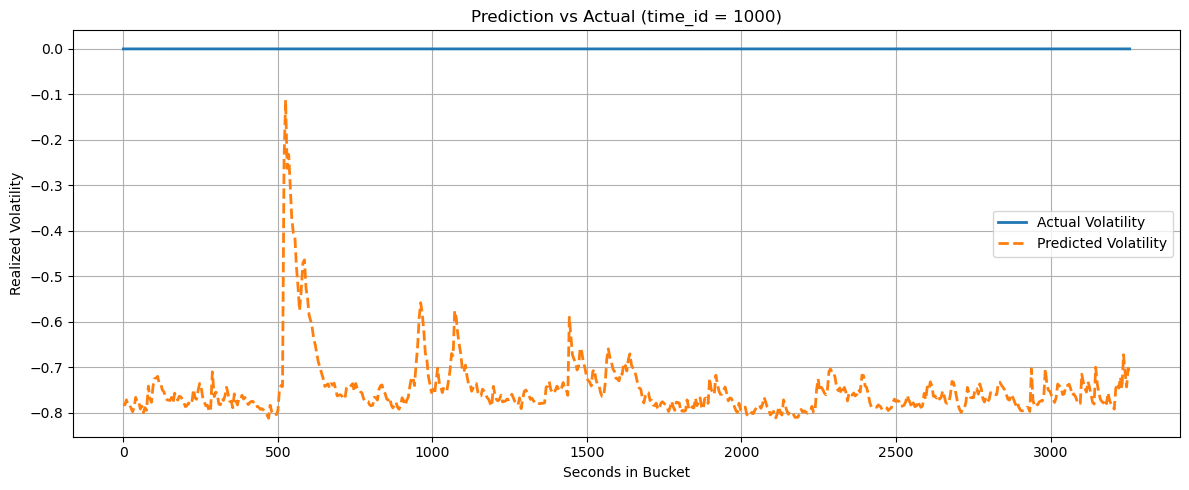

In [43]:
util.plot_prediction_vs_actual(results_df, 1000, y_true_col='y_true', y_pred_col='y_pred')